In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import numpyro

NDEVICES = 4 
numpyro.set_host_device_count(NDEVICES)

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from datetime import date, timedelta
from tqdm.auto import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax.random import PRNGKey

import mechafil.data as mecha_data
import mechafil.sim as np_sim
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting
import mechafil_jax.plot_utils as pu
import mechafil_jax.date_utils as du

import scenario_generator.utils as u
import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc

from cel_utils import disk_utils

In [4]:
save_dir = os.path.join(os.environ['HOME'], 'Documents/filp_scenarios')
offline_info_dir = os.path.join(save_dir, 'offline_info')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_info_dir, exist_ok=True)

In [5]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

current_date = date(2023,7,31) - timedelta(days=3)
start_date = date(current_date.year, current_date.month, 1)
forecast_length = 365*6
end_date = current_date + timedelta(days=forecast_length)

offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-07-01 2023-07-28 2029-07-26


In [6]:
def generate_mcmc_forecast_samples(train_start_date: date,
                                   train_end_date: date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2,
                                   verbose: bool = False):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, historical_rb_date, historical_rb, rb_rhats = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc,
                                       verbose = verbose)
    
    diagnostics = {
        'rb_rhats': rb_rhats,
    }
    return rb_onboard_power_pred, historical_rb_date, historical_rb, diagnostics

In [7]:
t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=365*2), current_date)
t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=365*2), current_date)
t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=365*2), current_date)
day_vec = np.arange(0,len(hist_fpr))

In [8]:
# MCMC forecasting configuration
mcmc_train_len_days = 180
mcmc_train_start_date = current_date - timedelta(days=(mcmc_train_len_days))
mcmc_train_end_date = mcmc_train_start_date + timedelta(days=mcmc_train_len_days)
num_warmup_mcmc = 10000
num_samples_mcmc = 500
seasonality_mcmc = 2000
num_chains_mcmc = 4

In [9]:
@disk_utils.cache_data(directory=offline_info_dir)
def run_mcmc():
    rb_onboard_power_pred, historical_rb_date, historical_rb, diagnostics = \
        generate_mcmc_forecast_samples(mcmc_train_start_date,
                                       mcmc_train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc,
                                       num_samples_mcmc,
                                       seasonality_mcmc,
                                       num_chains_mcmc,
                                       verbose=False)
    return {
        'rb_onboard_power_pred': rb_onboard_power_pred,
        'diagnostics': diagnostics
    }

mcmc_data = run_mcmc()
locals().update(mcmc_data)

# print mcmc diagnostics
rb_rhat_check = mcmc.check_rhat(diagnostics['rb_rhats'])
print('RBP Forecast RHat < 1.05: %0.02f %%' % (rb_rhat_check*100,))

RBP Forecast RHat < 1.05: 97.37 %


In [10]:
# logistic model for FPR forecast
def fpr_logistic_growth_model(x, y=None):
    # priors
    x0 = numpyro.sample("x0", dist.Normal(x.shape[0] // 2, 50)) # midpoint
    k = numpyro.sample("k", dist.Normal(0, 0.1)) # growth rate
    L = numpyro.sample("L", dist.Beta(1, 1)) # carrying capacity
    
    # logistic model
    filp = numpyro.deterministic("filp", L / (1 + jnp.exp(-k * (x - x0))))
    
    # Bernoulli likelihood version
    numpyro.sample(
        "obs",
        dist.Bernoulli(probs=filp),
        obs=y,
    )

In [11]:
def model_filp():
    filp_mcmc = MCMC(
        NUTS(fpr_logistic_growth_model, dense_mass=True),
        num_warmup=num_warmup_mcmc,
        num_samples=num_samples_mcmc,
        num_chains=num_chains_mcmc,
        progress_bar=True,
    )
    filp_mcmc.run(PRNGKey(1), x=day_vec, y=hist_fpr)
    filp_mcmc.print_summary()

    return {'filp_mcmc': filp_mcmc}

filp_data = model_filp()
locals().update(filp_data)

  0%|          | 0/10500 [00:00<?, ?it/s]

  0%|          | 0/10500 [00:00<?, ?it/s]

  0%|          | 0/10500 [00:00<?, ?it/s]

  0%|          | 0/10500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      0.90      0.05      0.90      0.81      0.98    879.50      1.00
         k      0.02      0.00      0.02      0.01      0.02    776.62      1.00
        x0    516.55     14.70    516.62    493.72    541.94    882.54      1.00

Number of divergences: 0


In [12]:
predictive = Predictive(fpr_logistic_growth_model, filp_mcmc.get_samples())
preds = predictive(PRNGKey(1), x=day_vec)["obs"]

In [13]:
carrying_capacity = filp_mcmc.get_samples()['L']
print("Carrying capacity mean and [Q10,Q90]:")
mu_L, q10q90_L = jnp.median(carrying_capacity),  jnp.percentile(carrying_capacity,  jnp.array([10, 90]), 0)
mu_L, q10q90_L

Carrying capacity mean and [Q10,Q90]:


(Array(0.8994762, dtype=float32),
 Array([0.82413113, 0.96505445], dtype=float32))

<IPython.core.display.Javascript object>


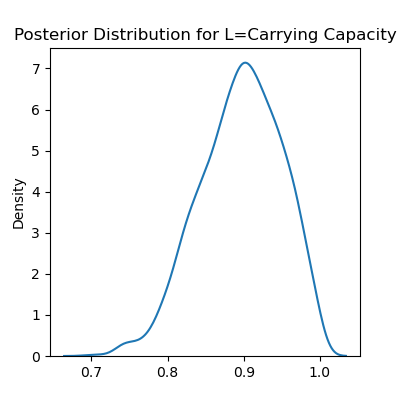

In [14]:
plt.figure(figsize=(4,4))
sns.kdeplot(carrying_capacity)
plt.title('Posterior Distribution for L=Carrying Capacity')
plt.savefig(os.path.join(save_dir, 'L_posterior.png'))

In [15]:
def compute_borrowing_cost(pledge, scaling_factor=0.1):
    return scaling_factor*pledge

def get_roi_cost(results, multiplier_vec, policy_update_idx, 
                 change_multiplier_after_policy_update=False,
                 borrowing_cost_pct_filp=0.5):
    days_1y = 365
    pledge = np.asarray(results['day_pledge_per_QAP'][:1-days_1y])
    returns = np.asarray(results['1y_return_per_sector'])
    assert len(pledge) == len(returns)
    m = multiplier_vec[:1-days_1y]
    
    p = pledge * m
    r = returns * m
    
    borrowing_costs = compute_borrowing_cost(p, scaling_factor=0.05)
    total_cost_idx = borrowing_costs[0]/borrowing_cost_pct_filp # @idx=0, we have multiplier=10
    fixed_costs_0 = total_cost_idx - borrowing_costs[0]
    tt = np.arange(0,len(p))
    fixed_costs = fixed_costs_0 * np.exp(-np.log(2.0)*tt/(365.0*3))
    total_costs = borrowing_costs + fixed_costs
    
    roi_with_cost = (r - total_costs) / p
    fc = np.ones(len(total_costs)) * fixed_costs

    return roi_with_cost, total_costs, fc, borrowing_costs, 

In [47]:
filp_scenarios = ['status_quo', '1x', '10x', 'rampdown-cliff', 'rampdown-linear']
# filp_scenarios = ['1x']
sunset_date = date(2024, 1, 1)
sunset_idx = int((sunset_date - start_date).days)

# for each trajectory, run mechaFIL and plot metrics: QAP/RBP
scenarios = defaultdict(list)
sunset_date_rbps = [5.0, 10.0, 15.0]

#lock_target = 0.3
lock_target = jnp.ones(forecast_length) * 0.3
sector_duration = 540
smooth_historical_rr = 0.5

num_total_days = (end_date-start_date).days
offset = (current_date-start_date).days
gamma_vec = jnp.ones(num_total_days)
gamma_weight_vec = jnp.zeros(num_total_days)
# change at policy update date
gamma_vec = gamma_vec.at[sunset_idx+offset:].set(0.1)
gamma_weight_vec = gamma_weight_vec.at[sunset_idx+offset:].set(2)

for filp_scenario in filp_scenarios:
    for ii in tqdm(range(num_chains_mcmc*num_samples_mcmc)):
        rr = jnp.ones(forecast_length) * smooth_historical_rr
        L = carrying_capacity[ii]
        
        fil_plus_m_vec = jnp.ones(forecast_length) * 10.0
        fpr = jnp.ones(forecast_length)
        if filp_scenario == 'status_quo':
            fpr *= L
    
        if filp_scenario == '1x':
            fpr = fpr.at[sunset_idx:].set(0.0)
            fil_plus_m_vec = fil_plus_m_vec.at[sunset_idx:].set(1.0)
            change_multiplier_after_policy_update = True
        elif filp_scenario == '10x':
            fpr = fpr.at[sunset_idx:].set(1.0)
            change_multiplier_after_policy_update = False
        elif filp_scenario == 'status_quo':
            change_multiplier_after_policy_update = False
        elif filp_scenario == 'rampdown-cliff':
            fil_plus_m_vec = fil_plus_m_vec.at[sunset_idx:].set(5.0)
            fil_plus_m_vec = fil_plus_m_vec.at[sunset_idx+180:].set(2.5)
            fil_plus_m_vec = fil_plus_m_vec.at[sunset_idx+180*2:].set(1.25)
            fil_plus_m_vec = fil_plus_m_vec.at[sunset_idx+180*3:].set(1.0)
            change_multiplier_after_policy_update = True
        elif filp_scenario == 'rampdown-linear':
            linear_ramp_down = jnp.linspace(10.0, 1.0, 180*3)
            fil_plus_m_vec = fil_plus_m_vec.at[sunset_idx:sunset_idx+180*3].set(linear_ramp_down)
            fil_plus_m_vec = fil_plus_m_vec.at[sunset_idx+180*3:].set(1.0)
            change_multiplier_after_policy_update = True

        reset_timeline_days = 900
        qa_relative_filp_m_vec = fil_plus_m_vec / 10.0
        qa_relative_filp_m_vec = qa_relative_filp_m_vec.at[sunset_idx:reset_timeline_days+sunset_idx].set(jnp.linspace(qa_relative_filp_m_vec[sunset_idx],1,reset_timeline_days))
        qa_relative_filp_m_vec = qa_relative_filp_m_vec.at[reset_timeline_days+sunset_idx:].set(1.0)  # reset after next wave of sectors expire
            
        for sunset_date_rbp in sunset_date_rbps:
            rbp = rb_onboard_power_pred[ii][0:forecast_length]
            rbp = rbp.at[sunset_idx:].set(sunset_date_rbp)
            
            simulation_results = sim.run_sim(
                rbp,
                rr,
                fpr,
                lock_target,

                start_date,
                current_date,
                forecast_length,
                sector_duration,
                offline_data,
                fil_plus_m=fil_plus_m_vec,
                qa_renew_relative_multiplier_vec=qa_relative_filp_m_vec,
                gamma=gamma_vec,
                gamma_weight_type=gamma_weight_vec
            )
            
            full_multiplier_vec = np.concatenate([np.ones(offset)*10.0, 
                                                  np.asarray(fil_plus_m_vec)])
            roi_with_cost, total_costs, fixed_costs, borrowing_costs = get_roi_cost(
                simulation_results, 
                multiplier_vec=full_multiplier_vec, 
                change_multiplier_after_policy_update=change_multiplier_after_policy_update,
                policy_update_idx=sunset_idx+extra_days,
                borrowing_cost_pct_filp=0.5
            )
            simulation_results['roi_with_cost'] = roi_with_cost
            simulation_results['total_costs'] = total_costs
            simulation_results['fixed_costs'] = fixed_costs
            simulation_results['borrowing_costs'] = borrowing_costs

            scenarios[(filp_scenario, int(sunset_date_rbp))].append(simulation_results)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


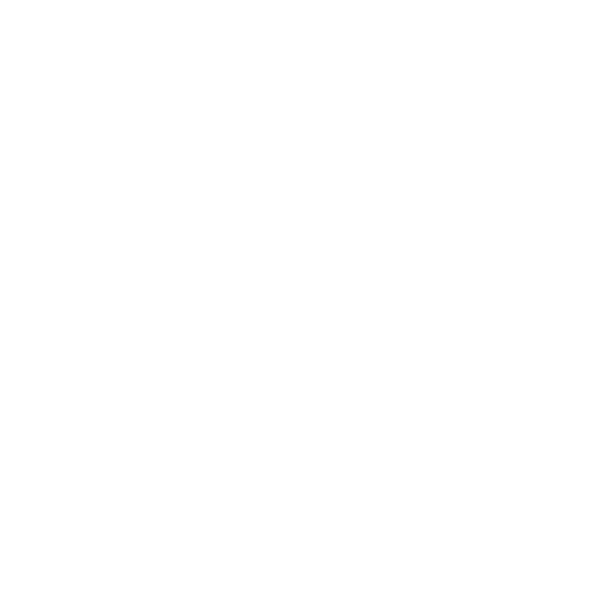

In [48]:
# plot rampdown-cliff scenario
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6,6), sharex=True, sharey=True)
plt_yrs = 3.5
plt_len = int(365*plt_yrs)
t = du.get_t(start_date, forecast_length=plt_len)

axx = ax[0,0]
sc1 = jnp.ones(forecast_length) * 10.0
sc1 = sc1.at[sunset_idx:].set(1.0)
axx.plot(t, sc1[0:plt_len])
axx.set_title('a) Option-1: 1x')
for tk in axx.get_xticklabels():
    tk.set_rotation(60)

axx = ax[0,1]
sc1 = jnp.ones(forecast_length) * 10.0
sc1 = sc1.at[sunset_idx:].set(5.0)
sc1 = sc1.at[sunset_idx+180:].set(2.5)
sc1 = sc1.at[sunset_idx+180*2:].set(1.25)
sc1 = sc1.at[sunset_idx+180*3:].set(1.0)
axx.plot(t, sc1[0:plt_len])
axx.set_title('b) Option-2: Cliff-Rampdown')
for tk in axx.get_xticklabels():
    tk.set_rotation(60)

axx = ax[1,0]
sc1 = jnp.ones(forecast_length) * 10.0
sc1 = sc1.at[sunset_idx:].set(10.0)
axx.plot(t, sc1[0:plt_len])
axx.set_title('c) Option-3: 10x')
for tk in axx.get_xticklabels():
    tk.set_rotation(60)


axx = ax[1,1]
# plot rampdown-cliff scenario
linear_ramp_down = jnp.linspace(10.0, 1.0, 180*3)
sc2 = jnp.ones(forecast_length) * 10.0
sc2 = sc2.at[sunset_idx:sunset_idx+180*3].set(linear_ramp_down)
sc2 = sc2.at[sunset_idx+180*3:].set(1.0)
axx.plot(t, sc2[0:plt_len])
axx.set_title('d) Option-4: Linear-Rampdown')
for tk in axx.get_xticklabels():
    tk.set_rotation(60)
plt.tight_layout()

plt.savefig(os.path.join(save_dir, 'filp_scenarios.png'))

In [49]:
def compute_quantiles(results, keys=['network_RBP_EIB'], xform=None, q=[0.05, 0.25, 0.50, 0.75, 0.95], startidx=None, endidx=None):
    key_vec = []
    for r in results:
        tmp_res = []
        for k in keys:
            tmp_res.append(r[k])
            
        if xform is None:
            key_vec.append(tmp_res[0])
        else:
            xx = xform(tmp_res)
            if xx is not None:
                key_vec.append(xx)
    key_vec = np.asarray(key_vec)
    if startidx is not None:
        key_vec = key_vec[:, startidx:]
    if endidx is not None:
        key_vec = key_vec[:, 0:endidx]
    return np.nanquantile(key_vec, q, axis=0)

In [50]:
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples'], mpl.colormaps['Reds']]

<IPython.core.display.Javascript object>


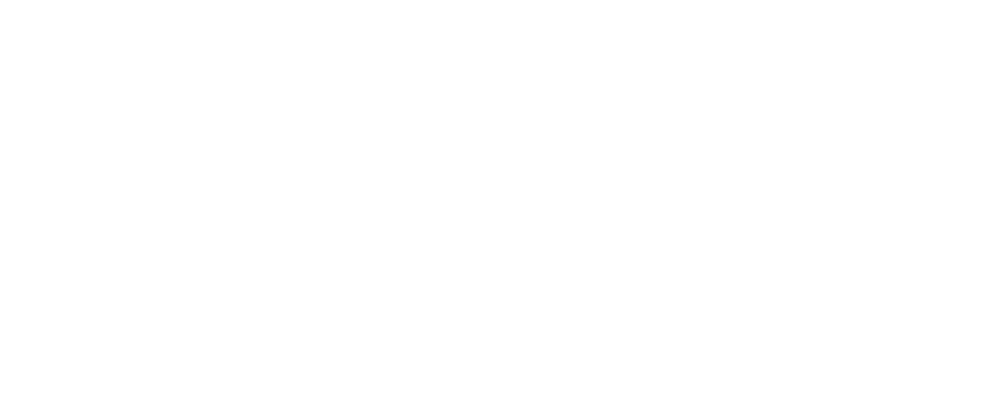

In [51]:
# plot ROI w/ cost along w/ FIL-P multiplier vector
scenario_to_plot = 'rampdown-linear'
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
q = compute_quantiles(scenarios[(scenario_to_plot, 5)], keys=['roi_with_cost'], endidx=plt_len)
t_roi = du.get_t(start_date, forecast_length=len(q[0]))
plt.plot(t_roi, q[2]*100, color=colors[0](0.8), label='RBP=%d' % (5,))
plt.fill_between(t_roi, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
q = compute_quantiles(scenarios[(scenario_to_plot, 10)], keys=['roi_with_cost'], endidx=plt_len)
t_roi = du.get_t(start_date, forecast_length=len(q[0]))
plt.plot(t_roi, q[2]*100, color=colors[1](0.8), label='RBP=%d' % (10,))
plt.fill_between(t_roi, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
q = compute_quantiles(scenarios[(scenario_to_plot, 15)], keys=['roi_with_cost'], endidx=plt_len)
t_roi = du.get_t(start_date, forecast_length=len(q[0]))
plt.plot(t_roi, q[2]*100, color=colors[2](0.8), label='RBP=%d' % (20,))
plt.fill_between(t_roi, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
plt.legend(loc='lower left')

ax2 = plt.twinx()
zz = fil_plus_m_vec = jnp.ones(forecast_length) * 10.0
linear_ramp_down = jnp.linspace(10.0, 1.0, 365*3)
zz = zz.at[sunset_idx:sunset_idx+365*3].set(linear_ramp_down)
zz = zz.at[sunset_idx+365*3:].set(1.0)
ax2.plot(t_roi, zz[0:len(t_roi)], color='k', label='FIL+ Multiplier')
ax2.legend()

plt.subplot(1,2,2)
q = compute_quantiles(scenarios[(scenario_to_plot, 5)], keys=['fixed_costs'], endidx=plt_len)
t_roi = du.get_t(start_date, forecast_length=len(q[0]))
plt.plot(t_roi, q[2]*100, color=colors[0](0.8), linestyle=':')
plt.fill_between(t_roi, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
# q = compute_quantiles(scenarios[(scenario_to_plot, 10)], keys=['fixed_costs'], endidx=plt_len)
# t_roi = du.get_t(start_date, forecast_length=len(q[0]))
# plt.plot(t_roi, q[2]*100, color=colors[1](0.8), linestyle=':')
# plt.fill_between(t_roi, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
# q = compute_quantiles(scenarios[(scenario_to_plot, 20)], keys=['fixed_costs'], endidx=plt_len)
# t_roi = du.get_t(start_date, forecast_length=len(q[0]))
# plt.plot(t_roi, q[2]*100, color=colors[2](0.8), linestyle=':')
# plt.fill_between(t_roi, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
# plt.legend(loc='lower left')

q = compute_quantiles(scenarios[(scenario_to_plot, 5)], keys=['borrowing_costs'], endidx=plt_len)
t_roi = du.get_t(start_date, forecast_length=len(q[0]))
plt.plot(t_roi, q[2]*100, color=colors[0](0.8), linestyle='--')
plt.fill_between(t_roi, q[1]*100, q[3]*100, color=colors[0](0.2), alpha=0.5)
# q = compute_quantiles(scenarios[(scenario_to_plot, 10)], keys=['total_costs'], endidx=plt_len)
# t_roi = du.get_t(start_date, forecast_length=len(q[0]))
# plt.plot(t_roi, q[2]*100, color=colors[1](0.8), linestyle='--')
# plt.fill_between(t_roi, q[1]*100, q[3]*100, color=colors[1](0.2), alpha=0.5)
# q = compute_quantiles(scenarios[(scenario_to_plot, 20)], keys=['total_costs'], endidx=plt_len)
# t_roi = du.get_t(start_date, forecast_length=len(q[0]))
# plt.plot(t_roi, q[2]*100, color=colors[2](0.8), linestyle='--')
# plt.fill_between(t_roi, q[1]*100, q[3]*100, color=colors[2](0.2), alpha=0.5)
# plt.legend(loc='lower left')
plt.plot(t_roi[0], 0, color='k', linestyle=':', label='Fixed Costs')
plt.plot(t_roi[0], 0, color='k', linestyle='--', label='Borrowing Costs')
plt.legend()

ax2 = plt.twinx()
zz = fil_plus_m_vec = jnp.ones(forecast_length) * 10.0
linear_ramp_down = jnp.linspace(10.0, 1.0, 365*3)
zz = zz.at[sunset_idx:sunset_idx+365*3].set(linear_ramp_down)
zz = zz.at[sunset_idx+365*3:].set(1.0)
ax2.plot(t_roi, zz[0:len(t_roi)], color='k', label='FIL+ Multiplier')
# ax2.legend()

In [52]:
plt_yrs = 3.5
plt_len = int(365*plt_yrs)
t = du.get_t(start_date, forecast_length=plt_len)

b_t = minting.compute_baseline_power_array(
    np.datetime64(start_date), np.datetime64(end_date), offline_data['init_baseline_eib'],
)

<IPython.core.display.Javascript object>


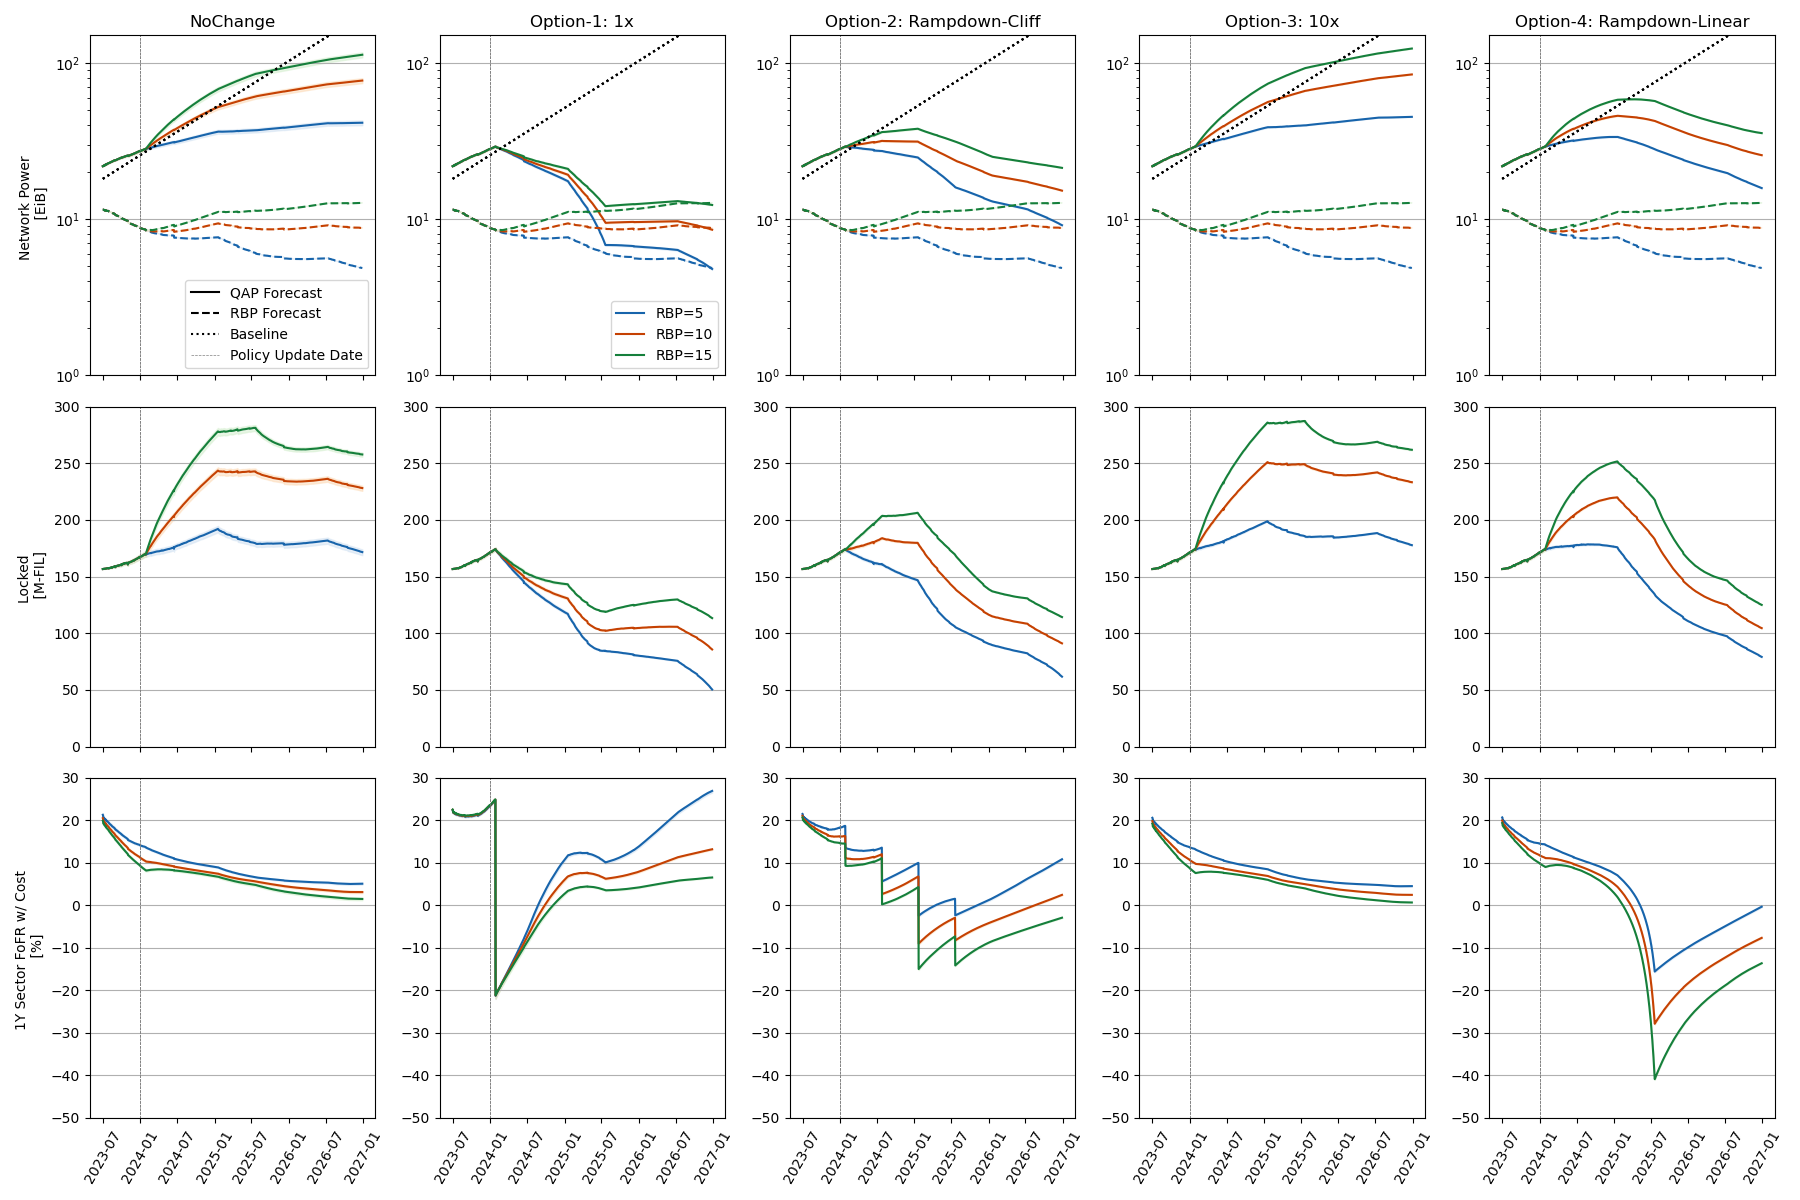

/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_58222/555842002.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axx.set_ylim(0)


In [54]:
# generate plot within time-bounds for the report

filp_scenarios_plot = ['status_quo', '1x', 'rampdown-cliff', '10x', 'rampdown-linear']
filp_scenarios_str = [ 'NoChange', 'Option-1: 1x', 'Option-2: Rampdown-Cliff', 'Option-3: 10x', 'Option-4: Rampdown-Linear']
fig, ax = plt.subplots(nrows=3, ncols=5, sharex=True, figsize=(18,12))

ix=0
for jj, scenario in enumerate(filp_scenarios_plot):
    axx = ax[ix,jj]
    axx.set_title(filp_scenarios_str[jj])
    for ii, sunset_rbp in enumerate(sunset_date_rbps):
        q = compute_quantiles(scenarios[(scenario, sunset_rbp)], keys=['network_QAP_EIB'], endidx=plt_len)
        axx.plot(t, q[2], color=colors[ii](0.8)) #, label='RBP=%d' % (sunset_rbp,))
        axx.fill_between(t, q[1], q[3], color=colors[ii](0.2), alpha=0.5)
        
        q = compute_quantiles(scenarios[(scenario, sunset_rbp)], keys=['network_RBP_EIB'], endidx=plt_len)
        axx.plot(t, q[2], color=colors[ii](0.8), linestyle='--') #, label='RBP=%d' % (sunset_rbp,))
        axx.fill_between(t, q[1], q[3], color=colors[ii](0.2), alpha=0.5, linestyle='--')
        
        axx.plot(t, b_t[0:plt_len], color='k', linestyle=':') #, label='Baseline')
        axx.axvline(sunset_date, color='grey', linestyle='--', linewidth=0.5)
        axx.set_yscale('log')
        if ii == 0 and jj == 0:
            axx.set_ylabel('Network Power \n [EiB]')
            axx.set_ylim(0)
        axx.grid(axis='y')
        for tk in axx.get_xticklabels():
            tk.set_rotation(60)

ax[0,2].set_ylim(1,150)
ax[0,0].sharey(ax[0,2])
ax[0,1].sharey(ax[0,2])
ax[0,3].sharey(ax[0,2])
ax[0,4].sharey(ax[0,2])

ax[0,0].plot(t[0],1, color='k', label='QAP Forecast')
ax[0,0].plot(t[0],1, color='k', linestyle='--', label='RBP Forecast')
ax[0,0].plot(t[0],1, color='k', linestyle=':', label='Baseline')
ax[0,0].plot(t[0],1, color='grey', linestyle='--', linewidth=0.5, label='Policy Update Date')
ax[0,0].legend()

ax[0,1].plot(t[0],1, color=colors[0](0.8), label='RBP=%d' % (sunset_date_rbps[0],))
ax[0,1].plot(t[0],1, color=colors[1](0.8), label='RBP=%d' % (sunset_date_rbps[1],))
ax[0,1].plot(t[0],1, color=colors[2](0.8), label='RBP=%d' % (sunset_date_rbps[2],))
ax[0,1].legend()
    
ix+=1
for jj, scenario in enumerate(filp_scenarios_plot):
    axx = ax[ix,jj]
    for ii, sunset_rbp in enumerate(sunset_date_rbps):
        q = compute_quantiles(scenarios[(scenario, sunset_rbp)], keys=['network_locked'], endidx=plt_len)
        axx.plot(t, q[2]/1e6, color=colors[ii](0.8), label='RBP=%d' % (sunset_rbp,))
        axx.fill_between(t, q[1]/1e6, q[3]/1e6, color=colors[ii](0.2), alpha=0.5)
        axx.axvline(sunset_date, color='grey', linestyle='--', linewidth=0.5)
        
        if ii == 0 and jj == 0:
            axx.set_ylabel('Locked \n [M-FIL]')
            axx.set_ylim(0)
        axx.grid(axis='y')
        for tk in axx.get_xticklabels():
            tk.set_rotation(60)
ax[ix,2].set_ylim(0,300)
ax[ix,0].sharey(ax[ix,2])
ax[ix,1].sharey(ax[ix,2])
ax[ix,3].sharey(ax[ix,2])
ax[ix,4].sharey(ax[ix,2])

ix+=1
for jj, scenario in enumerate(filp_scenarios_plot):
    axx = ax[ix,jj]
    for ii, sunset_rbp in enumerate(sunset_date_rbps):
        q = compute_quantiles(scenarios[(scenario, sunset_rbp)], keys=['roi_with_cost'], endidx=plt_len)
        t_roi = du.get_t(start_date, forecast_length=len(q[0]))
        axx.plot(t_roi, q[2]*100, color=colors[ii](0.8), label='RBP=%d' % (sunset_rbp,))
        axx.fill_between(t_roi, q[1]*100, q[3]*100, color=colors[ii](0.2), alpha=0.5)
        axx.axvline(sunset_date, color='grey', linestyle='--', linewidth=0.5)
        
        if ii == 0 and jj == 0:
            axx.set_ylabel('1Y Sector FoFR w/ Cost \n [%]')
            axx.set_ylim(0)
        axx.grid(axis='y')
        for tk in axx.get_xticklabels():
            tk.set_rotation(60)
        axx.set_ylim(-50,30)
# ax[ix,0].sharey(ax[ix,2])
# ax[ix,1].sharey(ax[ix,2])
# # ax[ix,2].sharey(ax[ix,4])
# ax[ix,3].sharey(ax[ix,2])
# ax[ix,4].sharey(ax[ix,2])

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'compare.png'))